## Импорты

In [46]:
import sys
from importlib import reload

sys.path.append("c:\\Users\\Юра\\VS_Code\\FastAPI_ML-project\\FastAPI_ML-project")
import utils.params

reload(utils.params)

from utils.params import bool_to_int, DATA_PATH, MODEL_PATH

In [47]:
for i in ['seaborn', 'phik', 'scikit-learn', 'statsmodels', 'memory_profiler', 'lightgbm', 'hdbscan']:
    try:
        __import__(i)
    except ImportError:
        !{sys.executable} -m pip install {i} -q



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

from sklearn.feature_selection import mutual_info_classif


from statsmodels.stats.outliers_influence import variance_inflation_factor
import gc

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import (
    StandardScaler, RobustScaler, FunctionTransformer
)

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier 


from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, 
    f1_score, roc_auc_score, precision_recall_curve
)


import joblib

from utils.params import MODEL_FILE

from src.python.model import ThresholdClassifierWithTransform



In [49]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

## Обработка данных

In [85]:
train = pd.read_csv(DATA_PATH / "heart_train.csv")
train.head(10)

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.360,0.732,0.074,1.000,1.000,1.000,1.000,1.000,0.536,1,1.000,0.000,8.000,0.226,0.106,0.459,0.979,3.000,0.333,0.000,0.227,0.048,0.037,Male,0.213,0.709,2664
1,1,0.202,0.325,0.048,1.000,1.000,0.000,0.000,1.000,0.069,2,1.000,0.000,9.000,0.290,0.164,0.117,0.516,3.000,0.833,0.000,0.150,0.018,0.000,Female,0.413,0.570,9287
2,2,0.607,0.861,0.056,1.000,0.000,1.000,1.000,1.000,0.944,2,1.000,1.000,6.000,0.550,0.599,0.374,0.013,2.000,1.000,0.000,0.227,0.048,0.037,Female,0.239,0.221,5379
3,3,0.730,0.007,0.053,0.000,0.000,1.000,0.000,1.000,0.697,0,0.000,1.000,3.000,0.331,0.078,0.050,0.131,0.000,0.333,1.000,0.227,0.048,0.037,Female,0.348,0.267,8222
4,4,0.775,0.757,0.022,0.000,0.000,1.000,0.000,1.000,0.413,1,0.000,0.000,8.000,0.525,0.342,0.830,0.070,5.000,1.000,1.000,0.227,0.048,0.037,Male,0.619,0.442,4047
5,5,0.169,0.764,0.058,0.000,1.000,1.000,1.000,1.000,0.083,1,1.000,0.000,7.000,0.558,0.641,0.111,0.239,6.000,0.833,0.000,0.227,0.048,0.037,Male,0.465,0.419,5817
6,6,0.483,0.021,0.037,1.000,0.000,1.000,0.000,1.000,0.540,2,0.000,1.000,9.000,0.828,0.775,0.074,0.073,5.000,0.000,1.000,0.231,0.009,0.000,Male,0.361,0.570,5580
7,7,0.236,0.939,0.082,1.000,0.000,1.000,0.000,1.000,0.291,2,0.000,1.000,7.000,0.225,0.999,0.002,0.181,4.000,0.000,0.000,0.227,0.048,0.037,Male,0.690,0.640,4963
8,8,0.685,0.318,0.039,0.000,0.000,1.000,0.000,0.000,0.803,0,1.000,1.000,3.000,0.828,0.142,0.093,0.991,6.000,0.167,1.000,0.126,0.002,0.007,Male,0.665,0.616,4521
9,9,0.213,0.796,0.077,1.000,1.000,1.000,1.000,0.000,0.507,1,0.000,0.000,7.000,0.693,0.821,0.145,0.171,3.000,1.000,0.000,0.227,0.048,0.037,Male,0.652,0.721,2455


In [51]:
train.columns = train.columns.str.lower().str.replace(r'[\s\-\.]+', '_', regex=True)

In [52]:
pd.DataFrame({
    'dtype': train.dtypes,
    'nunique': train.nunique(),
    'missing': train.isnull().sum()
})

,dtype,nunique,missing
unnamed:_0,int64,8685,0
age,float64,77,0
cholesterol,float64,282,0
heart_rate,float64,87,0
diabetes,float64,2,243
family_history,float64,2,243
smoking,float64,2,243
obesity,float64,2,243
alcohol_consumption,float64,2,243
exercise_hours_per_week,float64,7933,0


In [53]:
train['gender'].unique()

array(['Male', 'Female', '1.0', '0.0'], dtype=object)


Полагаю что 1 и 0 означает пол(мужской и женский). Прикинем что к чему относится
### Исправление gender

In [54]:
train[train['gender'] == '1.0'].describe()

,unnamed:_0,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_(binary),blood_sugar,ck_mb,troponin,systolic_blood_pressure,diastolic_blood_pressure,id
count,156.000,156.000,156.000,156.000,0.000,0.000,0.000,0.000,0.000,156.000,156.000,0.000,0.000,0.000,156.000,156.000,156.000,156.000,0.000,156.000,156.000,156.000,156.000,156.000,156.000,156.000,156.000
mean,4631.679,0.487,0.500,0.060,NaN,NaN,NaN,NaN,NaN,0.502,3.000,NaN,NaN,NaN,0.500,0.495,0.495,0.504,NaN,0.505,0.000,0.205,0.066,0.039,0.390,0.352,9516.974
std,2465.447,0.150,0.000,0.020,NaN,NaN,NaN,NaN,NaN,0.000,0.000,NaN,NaN,NaN,0.000,0.000,0.000,0.000,NaN,0.000,0.000,0.125,0.174,0.098,0.142,0.155,79.591
min,16.000,0.146,0.500,0.015,NaN,NaN,NaN,NaN,NaN,0.502,3.000,NaN,NaN,NaN,0.500,0.495,0.495,0.504,NaN,0.505,0.000,0.053,0.000,0.000,0.000,0.000,9377.000
25%,2618.750,0.393,0.500,0.046,NaN,NaN,NaN,NaN,NaN,0.502,3.000,NaN,NaN,NaN,0.500,0.495,0.495,0.504,NaN,0.505,0.000,0.121,0.004,0.000,0.295,0.244,9445.750
50%,4852.000,0.517,0.500,0.057,NaN,NaN,NaN,NaN,NaN,0.502,3.000,NaN,NaN,NaN,0.500,0.495,0.495,0.504,NaN,0.505,0.000,0.152,0.009,0.002,0.355,0.355,9518.500
75%,6606.250,0.576,0.500,0.070,NaN,NaN,NaN,NaN,NaN,0.502,3.000,NaN,NaN,NaN,0.500,0.495,0.495,0.504,NaN,0.505,0.000,0.249,0.025,0.026,0.466,0.442,9585.250
max,8639.000,0.966,0.500,0.105,NaN,NaN,NaN,NaN,NaN,0.502,3.000,NaN,NaN,NaN,0.500,0.495,0.495,0.504,NaN,0.505,0.000,0.737,1.000,0.806,0.929,0.791,9650.000


In [55]:
train[train['gender'] == '0.0'].describe()

,unnamed:_0,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_(binary),blood_sugar,ck_mb,troponin,systolic_blood_pressure,diastolic_blood_pressure,id
count,87.000,87.000,87.000,87.000,0.000,0.000,0.000,0.000,0.000,87.000,87.000,0.000,0.000,0.000,87.000,87.000,87.000,87.000,0.000,87.000,87.000,87.000,87.000,87.000,87.000,87.000,87.000
mean,3892.471,0.475,0.500,0.079,NaN,NaN,NaN,NaN,NaN,0.502,3.000,NaN,NaN,NaN,0.500,0.495,0.495,0.504,NaN,0.505,0.000,0.204,0.056,0.015,0.397,0.367,9511.218
std,2344.792,0.181,0.000,0.143,NaN,NaN,NaN,NaN,NaN,0.000,0.000,NaN,NaN,NaN,0.000,0.000,0.000,0.000,NaN,0.000,0.000,0.129,0.185,0.053,0.189,0.185,78.854
min,92.000,0.000,0.500,0.000,NaN,NaN,NaN,NaN,NaN,0.502,3.000,NaN,NaN,NaN,0.500,0.495,0.495,0.504,NaN,0.505,0.000,0.030,0.000,0.000,0.071,0.058,9379.000
25%,1693.000,0.371,0.500,0.046,NaN,NaN,NaN,NaN,NaN,0.502,3.000,NaN,NaN,NaN,0.500,0.495,0.495,0.504,NaN,0.505,0.000,0.118,0.005,0.000,0.258,0.215,9446.000
50%,3969.000,0.494,0.500,0.057,NaN,NaN,NaN,NaN,NaN,0.502,3.000,NaN,NaN,NaN,0.500,0.495,0.495,0.504,NaN,0.505,0.000,0.168,0.008,0.001,0.381,0.360,9512.000
75%,5712.000,0.579,0.500,0.069,NaN,NaN,NaN,NaN,NaN,0.502,3.000,NaN,NaN,NaN,0.500,0.495,0.495,0.504,NaN,0.505,0.000,0.240,0.019,0.002,0.490,0.465,9580.000
max,8619.000,1.000,0.500,1.000,NaN,NaN,NaN,NaN,NaN,0.502,3.000,NaN,NaN,NaN,0.500,0.495,0.495,0.504,NaN,0.505,0.000,0.789,1.000,0.374,1.000,1.000,9646.000


In [56]:
train[train['gender'] == 'Male'].describe()

,unnamed:_0,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_(binary),blood_sugar,ck_mb,troponin,systolic_blood_pressure,diastolic_blood_pressure,id
count,5882.000,5882.000,5882.000,5882.000,5882.000,5882.000,5882.000,5882.000,5882.000,5882.000,5882.000,5882.000,5882.000,5882.000,5882.000,5882.000,5882.000,5882.000,5882.000,5882.000,5882.000,5882.000,5882.000,5882.000,5882.000,5882.000,5882.000
mean,4364.208,0.452,0.502,0.050,0.653,0.493,1.000,0.497,0.599,0.503,0.997,0.497,0.501,5.464,0.501,0.497,0.498,0.508,3.495,0.502,0.359,0.228,0.047,0.037,0.451,0.501,4686.086
std,2513.673,0.233,0.289,0.018,0.476,0.500,0.000,0.500,0.490,0.288,0.813,0.500,0.500,2.865,0.289,0.290,0.290,0.288,2.277,0.331,0.480,0.076,0.064,0.059,0.170,0.169,2705.793
min,0.000,0.045,0.000,0.018,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.161,0.209,1.000
25%,2181.250,0.258,0.261,0.035,0.000,0.000,1.000,0.000,0.000,0.252,0.000,0.000,0.000,3.000,0.249,0.245,0.244,0.261,2.000,0.167,0.000,0.227,0.048,0.037,0.303,0.360,2351.750
50%,4363.500,0.461,0.500,0.049,1.000,0.000,1.000,0.000,1.000,0.508,1.000,0.000,1.000,5.000,0.497,0.495,0.493,0.512,3.000,0.500,0.000,0.227,0.048,0.037,0.452,0.500,4686.000
75%,6556.750,0.640,0.750,0.066,1.000,1.000,1.000,1.000,1.000,0.752,2.000,1.000,1.000,8.000,0.752,0.752,0.749,0.760,5.000,0.833,1.000,0.227,0.048,0.037,0.600,0.651,7001.750
max,8684.000,0.854,1.000,0.082,1.000,1.000,1.000,1.000,1.000,1.000,2.000,1.000,1.000,10.000,0.999,1.000,1.000,1.000,7.000,1.000,1.000,1.000,1.000,1.000,0.742,0.791,9376.000


In [57]:
train[train['gender'] == 'Female'].describe()

,unnamed:_0,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_(binary),blood_sugar,ck_mb,troponin,systolic_blood_pressure,diastolic_blood_pressure,id
count,2560.000,2560.000,2560.000,2560.000,2560.000,2560.000,2560.000,2560.000,2560.000,2560.000,2560.000,2560.000,2560.000,2560.000,2560.000,2560.000,2560.000,2560.000,2560.000,2560.000,2560.000,2560.000,2560.000,2560.000,2560.000,2560.000,2560.000
mean,4288.598,0.443,0.499,0.051,0.649,0.483,0.680,0.501,0.609,0.504,1.011,0.491,0.502,5.561,0.495,0.493,0.495,0.501,3.539,0.507,0.352,0.227,0.050,0.037,0.453,0.502,4720.073
std,2498.663,0.233,0.289,0.018,0.477,0.500,0.467,0.500,0.488,0.291,0.813,0.500,0.500,2.875,0.289,0.286,0.279,0.295,2.293,0.336,0.478,0.070,0.084,0.061,0.171,0.173,2702.808
min,1.000,0.045,0.000,0.018,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.030,0.000,0.000,0.161,0.209,8.000
25%,2155.500,0.247,0.257,0.035,0.000,0.000,0.000,0.000,0.000,0.254,0.000,0.000,0.000,3.000,0.244,0.242,0.259,0.242,1.000,0.167,0.000,0.227,0.048,0.037,0.303,0.349,2365.750
50%,4277.500,0.449,0.489,0.050,1.000,0.000,1.000,1.000,1.000,0.508,1.000,0.000,1.000,6.000,0.484,0.500,0.485,0.499,4.000,0.500,0.000,0.227,0.048,0.037,0.452,0.500,4720.500
75%,6414.250,0.640,0.757,0.067,1.000,1.000,1.000,1.000,1.000,0.764,2.000,1.000,1.000,8.000,0.747,0.734,0.736,0.757,6.000,0.833,1.000,0.227,0.048,0.037,0.606,0.651,7082.500
max,8678.000,0.854,1.000,0.082,1.000,1.000,1.000,1.000,1.000,1.000,2.000,1.000,1.000,10.000,1.000,1.000,1.000,1.000,7.000,1.000,1.000,0.806,1.000,0.971,0.742,0.791,9373.000


Отличить женщин от мужчин оказалось не так просто, но предполагаю что так как мужчин в таблице больше то больше будет мужчин которым поставили цифру вместо пола, следовательно мужчины соответствуют цифре 1 а женщины 0. теперь можно приводить типы

In [58]:
def gender_to_boll(x):
    if x in ['Male', '1.0']:
        return 1
    elif x in ['Female', '0.0']:
        return 0
    else:
        return np.nan
train['gender'] = train['gender'].apply(gender_to_boll)

train['gender'].unique()

array([1, 0])

### Обработка пропусков

видим что пропусков около 243 что сильно меньше размера таблицы, так что можем их безопасно отрезать

In [59]:
train.shape

(8685, 28)

In [60]:
train = train.dropna()
train.isnull().sum()

unnamed:_0                         0
age                                0
cholesterol                        0
heart_rate                         0
diabetes                           0
family_history                     0
smoking                            0
obesity                            0
alcohol_consumption                0
exercise_hours_per_week            0
diet                               0
previous_heart_problems            0
medication_use                     0
stress_level                       0
sedentary_hours_per_day            0
income                             0
bmi                                0
triglycerides                      0
physical_activity_days_per_week    0
sleep_hours_per_day                0
heart_attack_risk_(binary)         0
blood_sugar                        0
ck_mb                              0
troponin                           0
gender                             0
systolic_blood_pressure            0
diastolic_blood_pressure           0
i

In [61]:
train.shape

(8442, 28)

### Приведение типов

In [62]:

for i in ['diabetes', \
          'gender',	'family_history',	\
          'smoking', 'obesity', 'alcohol_consumption', \
          'previous_heart_problems',	'medication_use',\
          'heart_attack_risk_(binary)']:
    train[i] = train[i].astype('bool')
train['stress_level'] = train['stress_level'].astype('int')
for i in ['physical_activity_days_per_week', 'stress_level']:
    train[i] = train[i].astype('int64')


In [63]:
pd.DataFrame({
    "Non-Null Count": train.notnull().sum(),
    "Dtype": train.dtypes,
    'Unique Values': train.nunique()
})


,Non-Null Count,Dtype,Unique Values
unnamed:_0,8442,int64,8442
age,8442,float64,73
cholesterol,8442,float64,281
heart_rate,8442,float64,71
diabetes,8442,bool,2
family_history,8442,bool,2
smoking,8442,bool,2
obesity,8442,bool,2
alcohol_consumption,8442,bool,2
exercise_hours_per_week,8442,float64,7932


In [64]:
if 'unnamed:_0' in train.columns: train = train[train.columns.drop(['unnamed:_0'])]
train.duplicated(subset=train.columns.drop('id', 'heart_attack_risk_(binary)')).sum()

np.int64(0)

In [65]:
train.apply(lambda x: x.unique())

age                                [0.3595505617977527, 0.2022471910112359, 0.606...
cholesterol                        [0.732142857142857, 0.325, 0.8607142857142855,...
heart_rate                         [0.074243813015582, 0.0476626947754353, 0.0559...
diabetes                                                               [True, False]
family_history                                                         [True, False]
smoking                                                                [True, False]
obesity                                                                [True, False]
alcohol_consumption                                                    [True, False]
exercise_hours_per_week            [0.5355049297181428, 0.068689995709055, 0.9440...
diet                                                                       [1, 2, 0]
previous_heart_problems                                                [True, False]
medication_use                                                   

## Исследовательский анализ данных

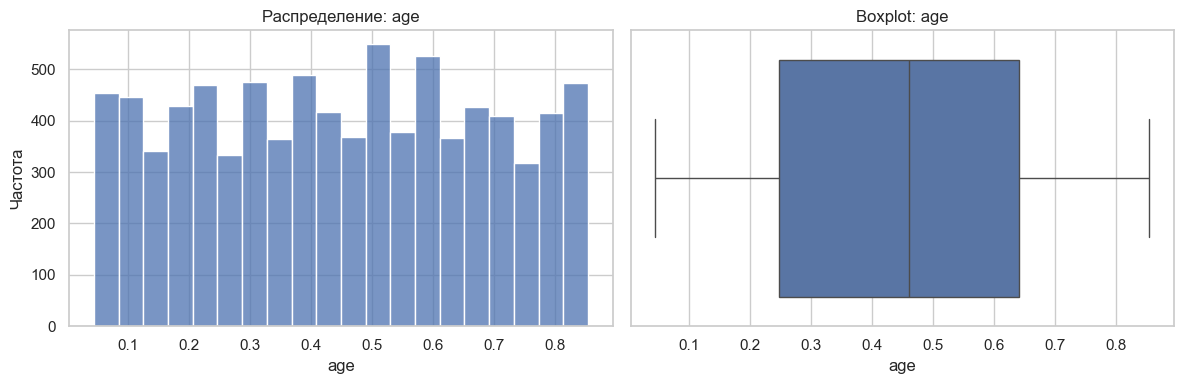

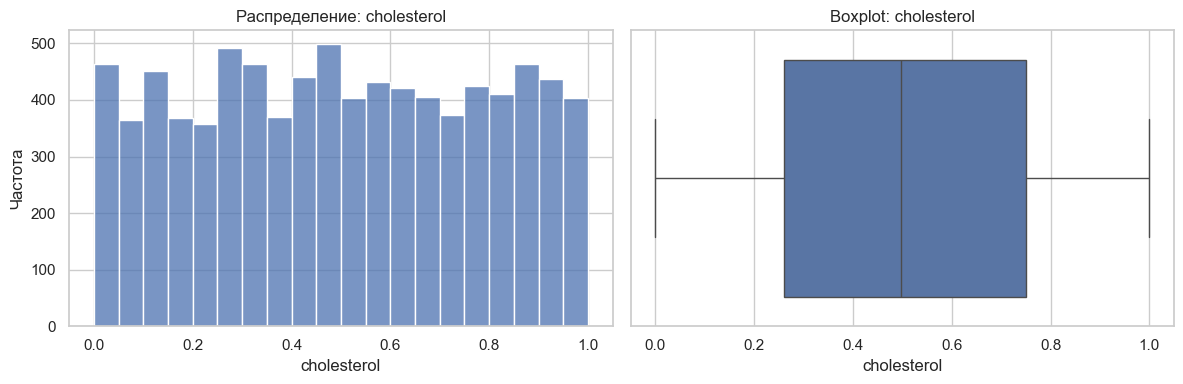

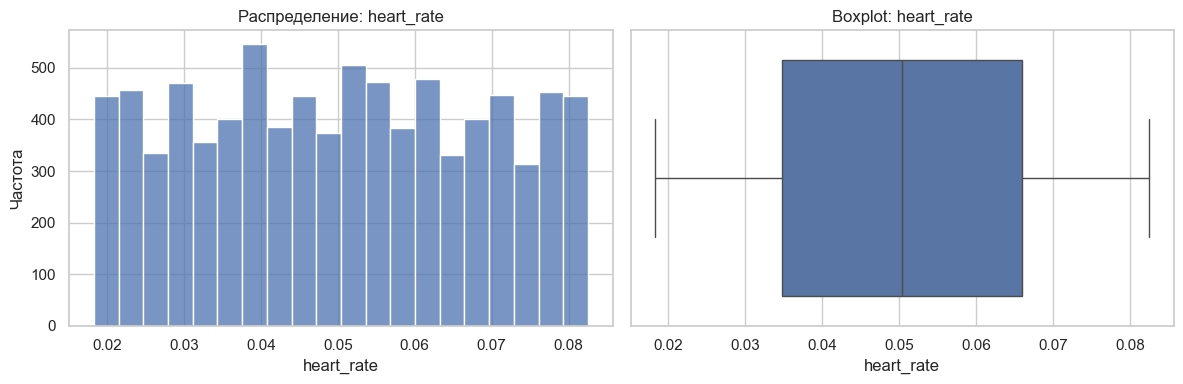

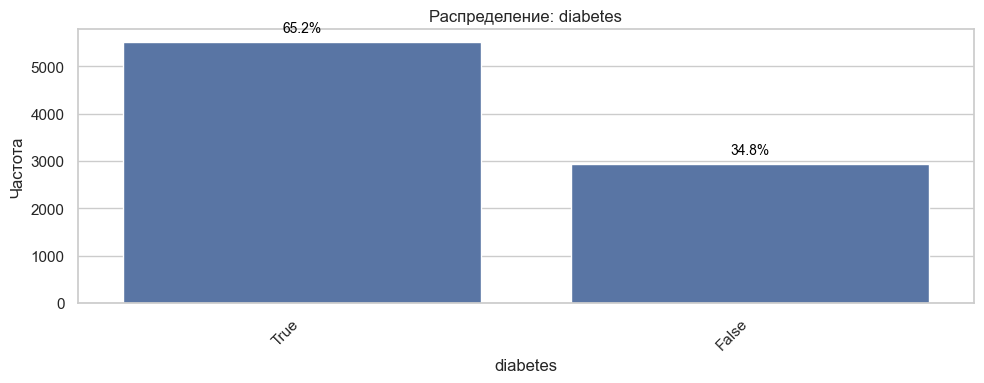

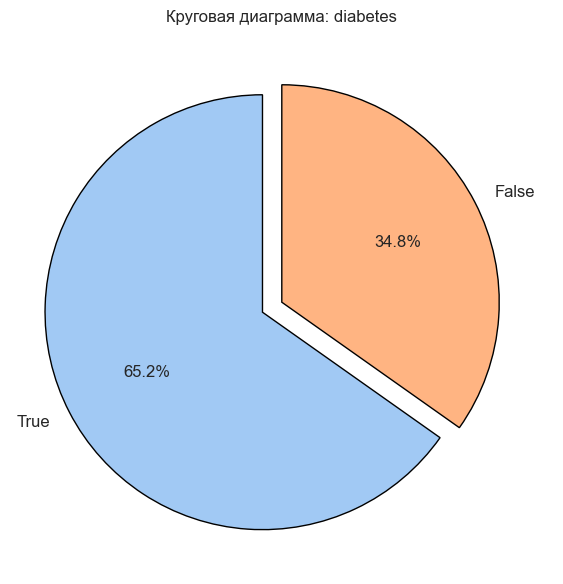

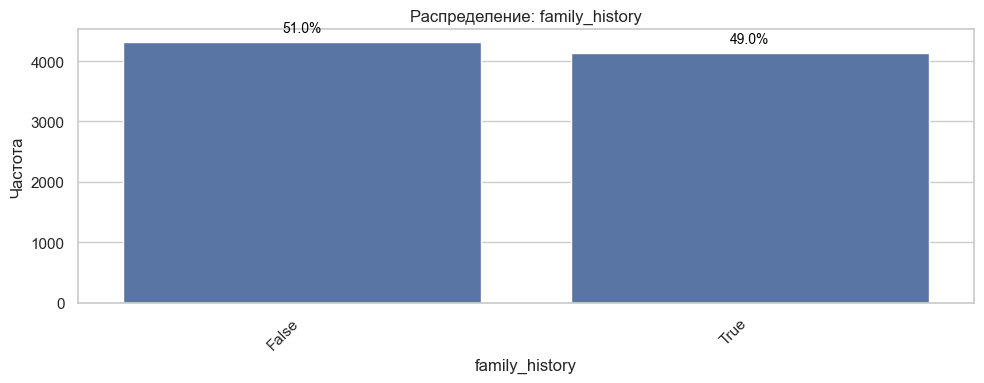

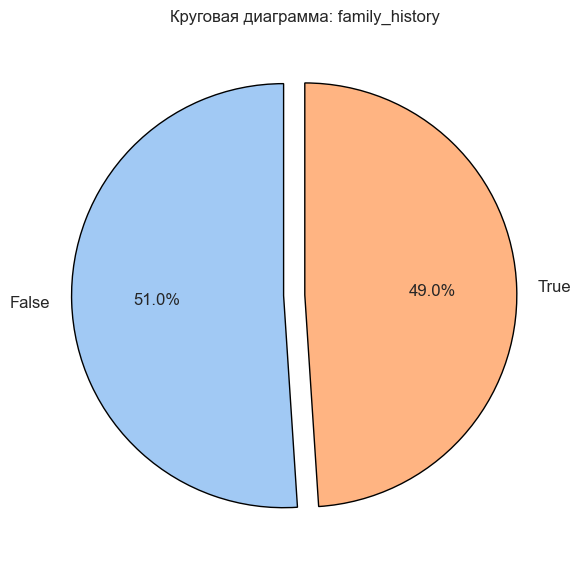

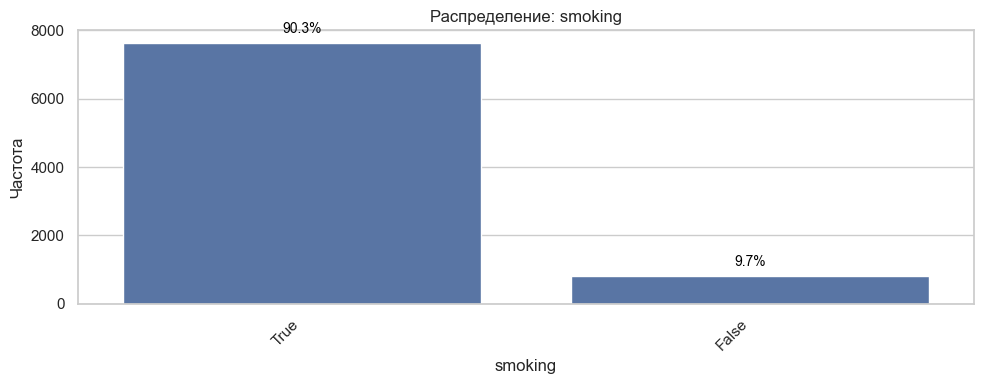

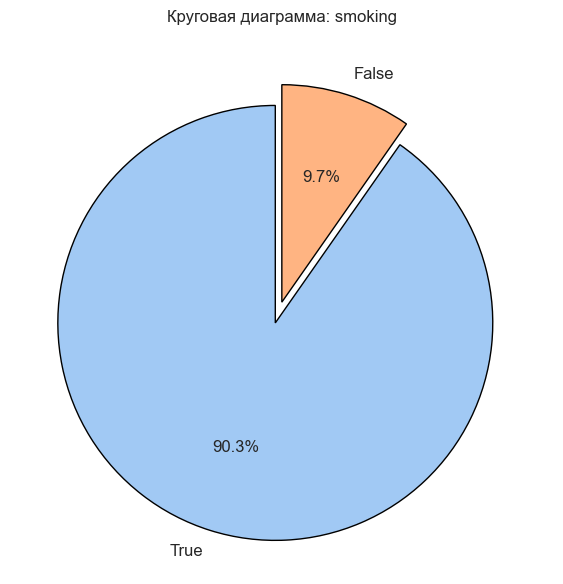

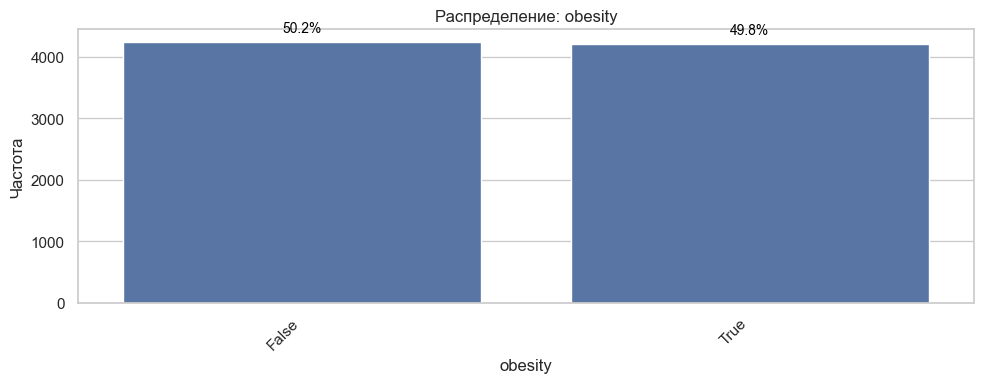

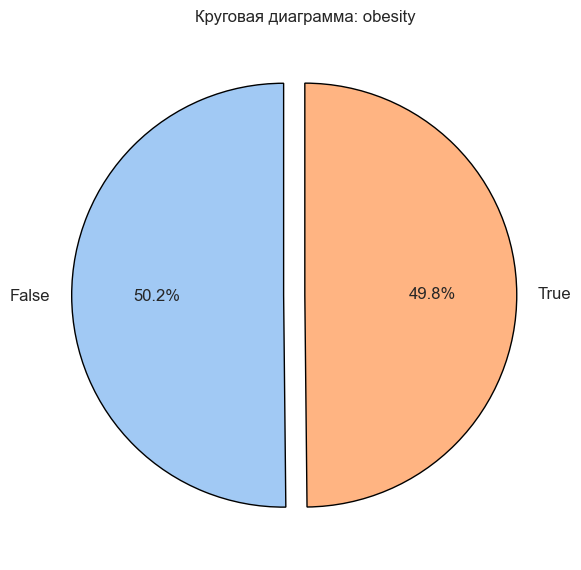

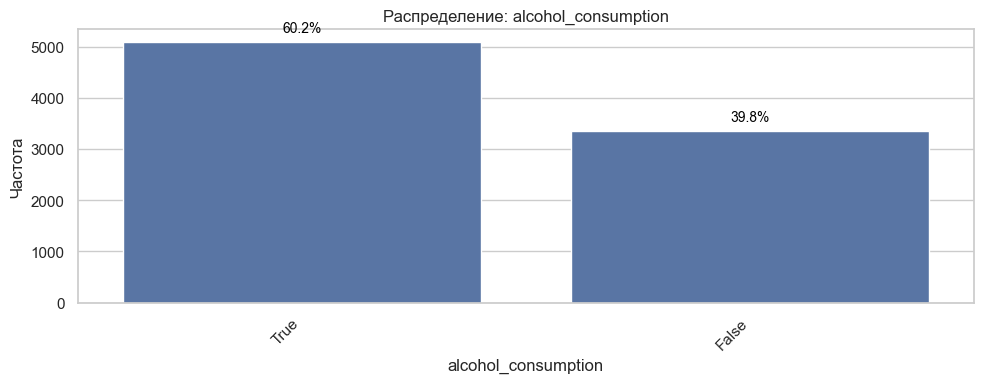

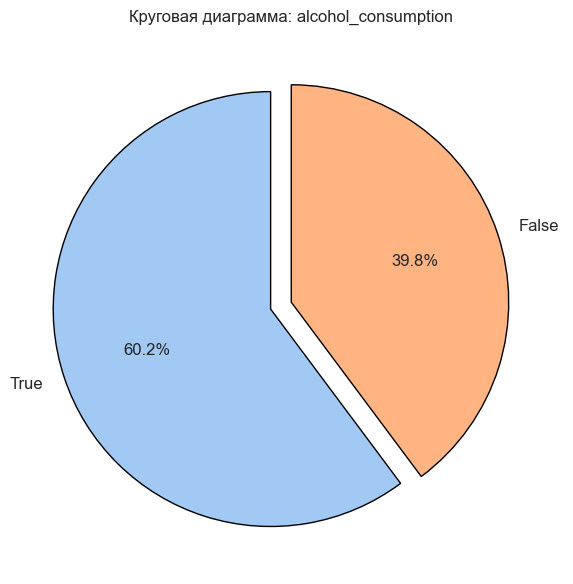

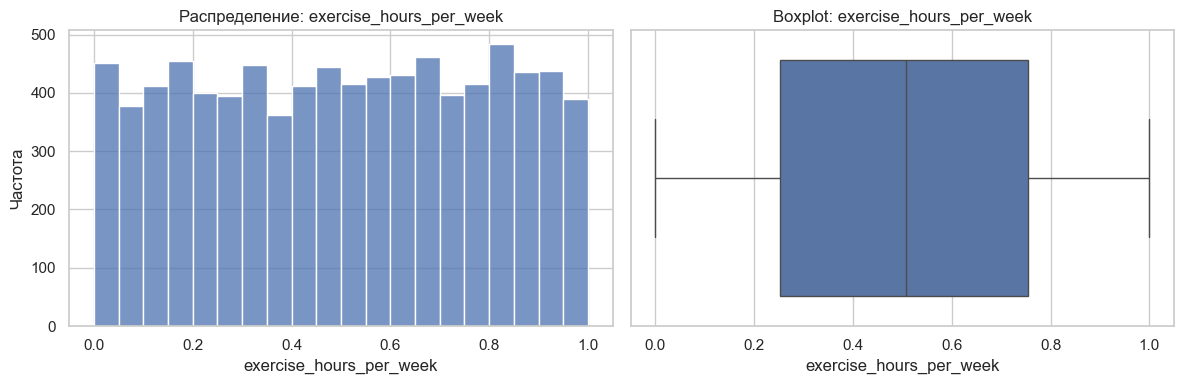

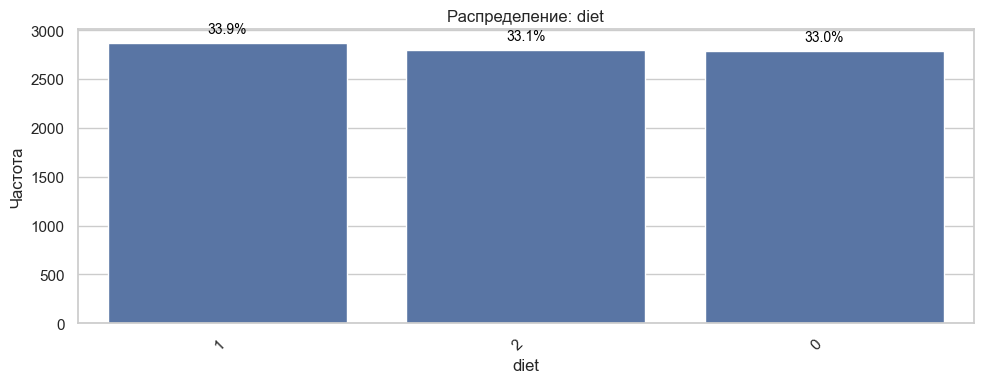

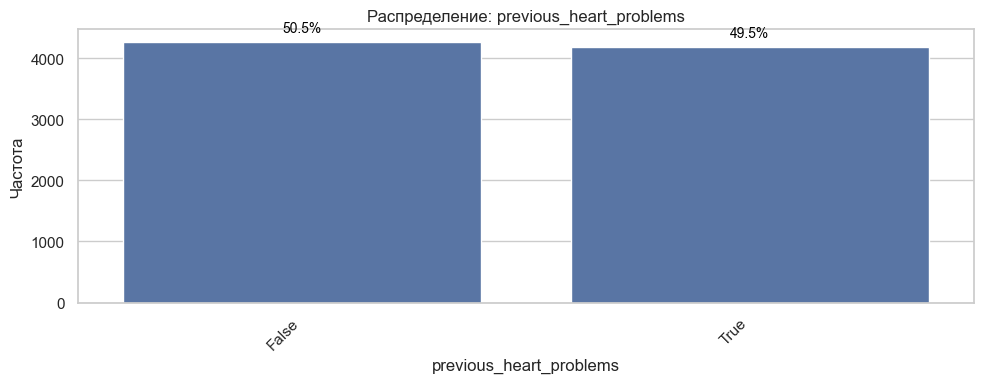

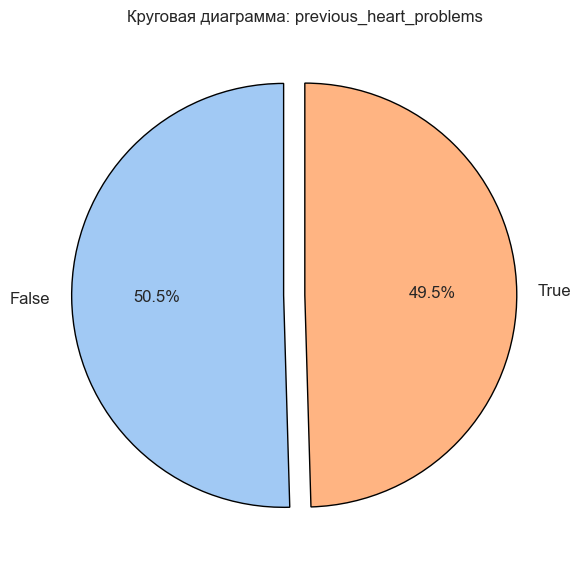

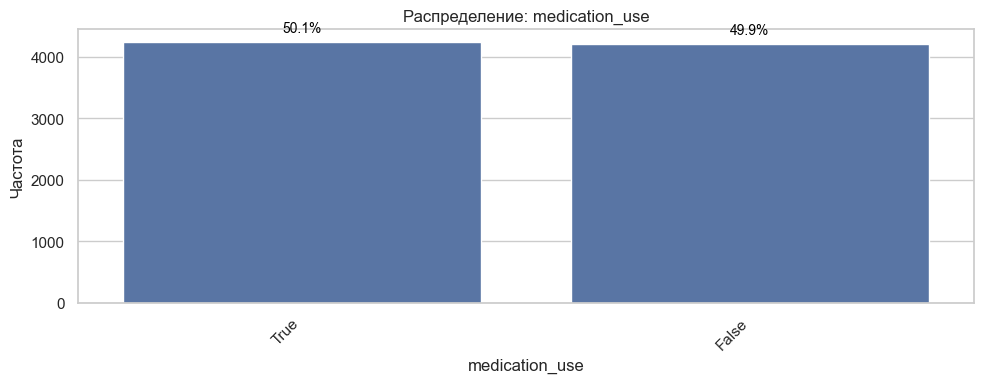

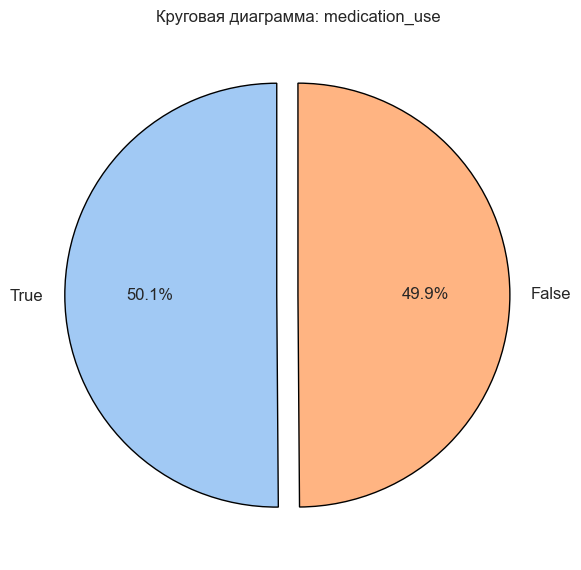

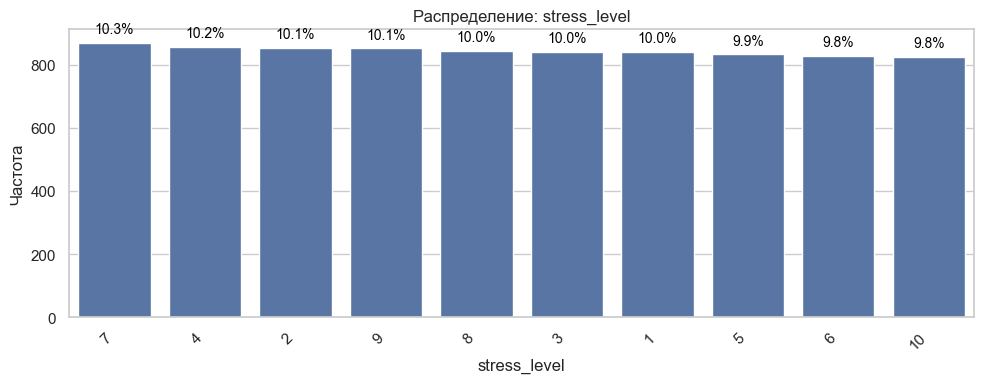

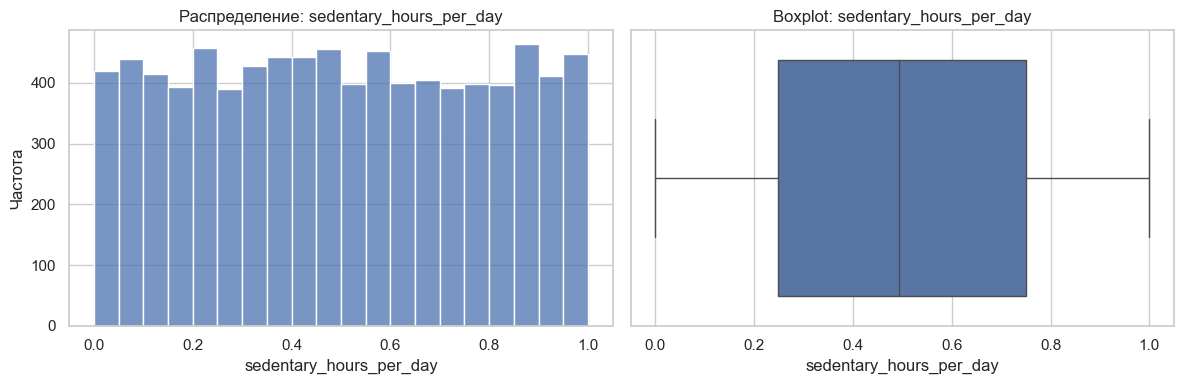

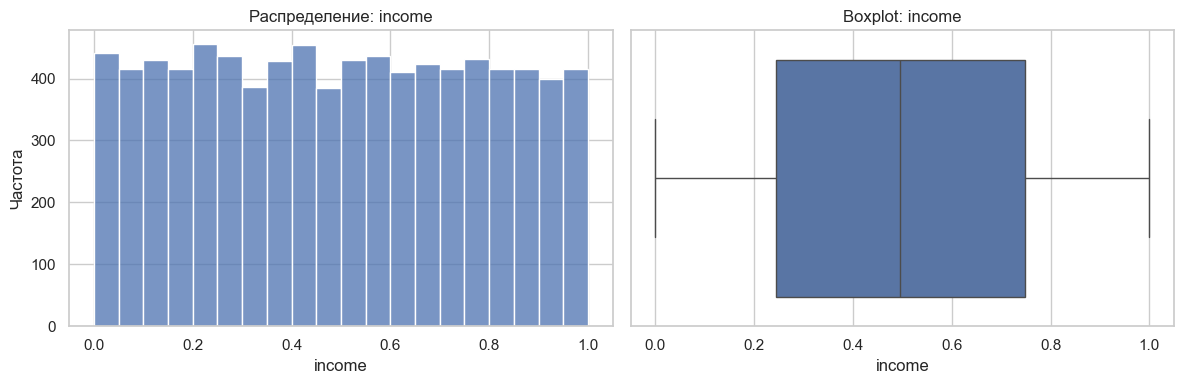

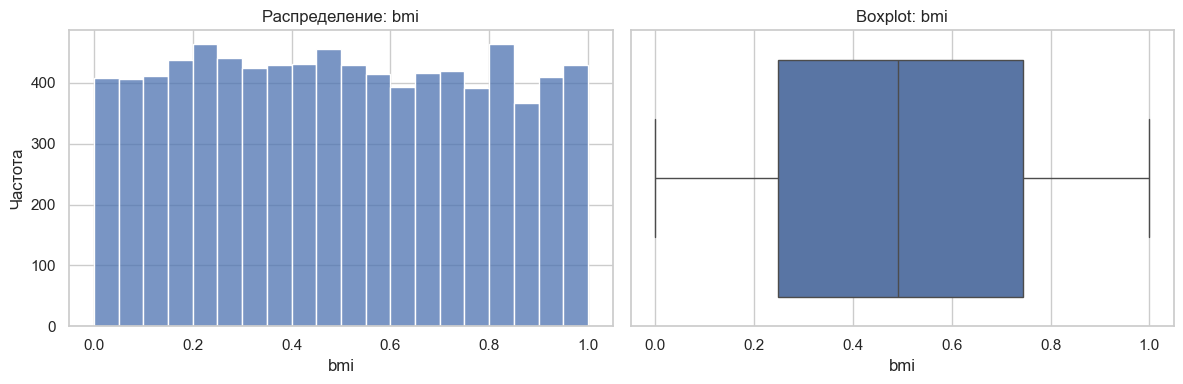

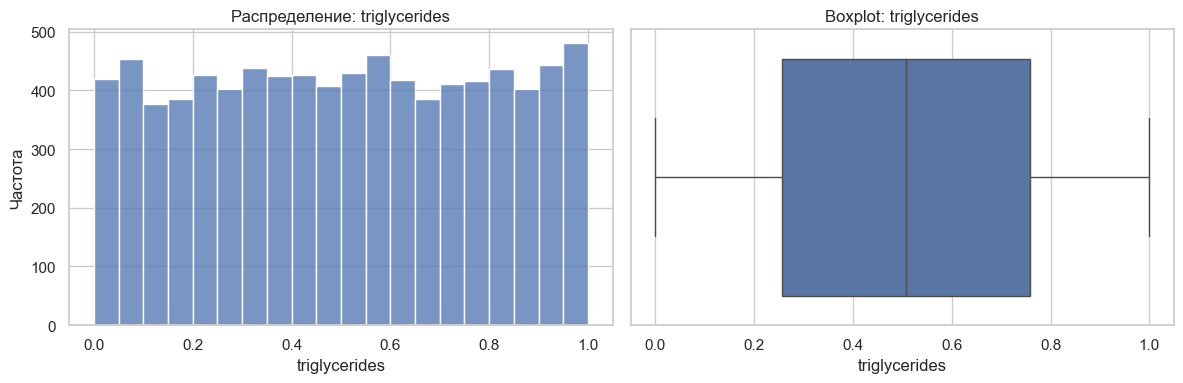

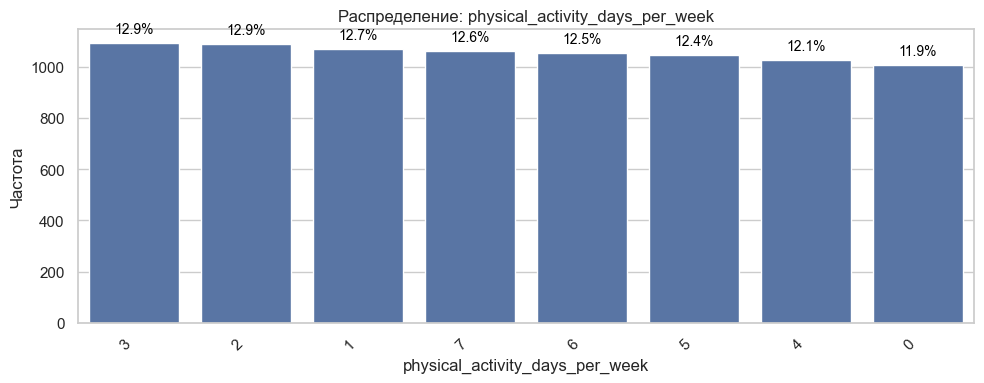

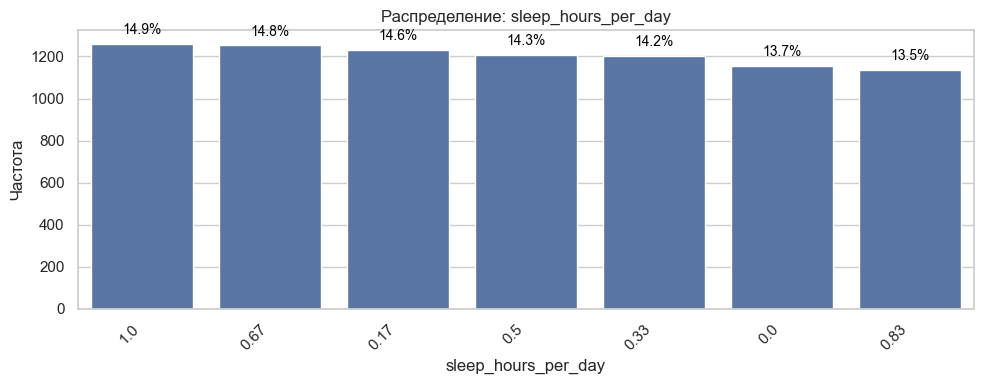

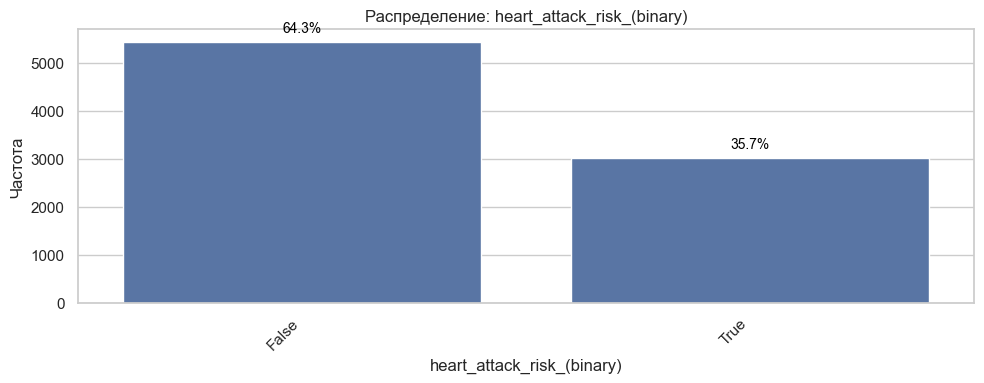

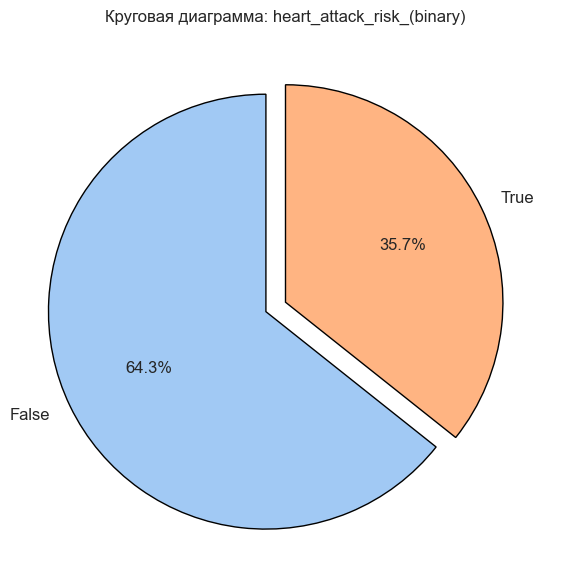

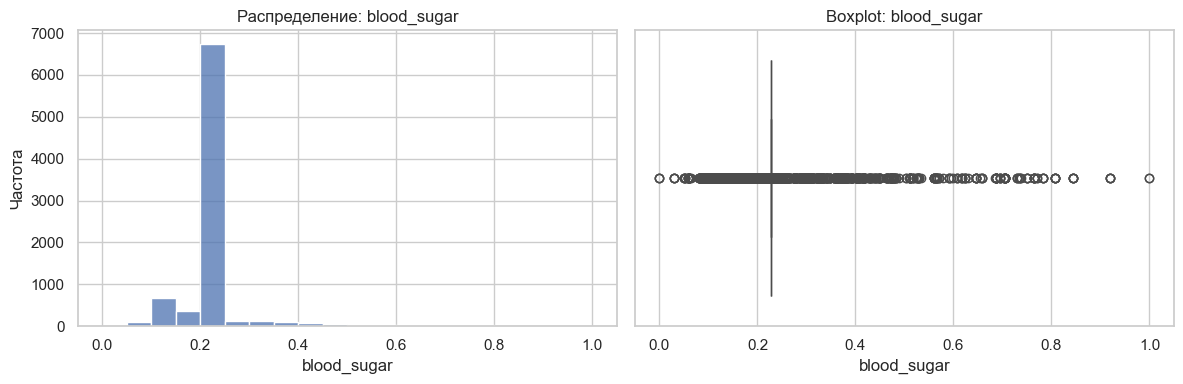

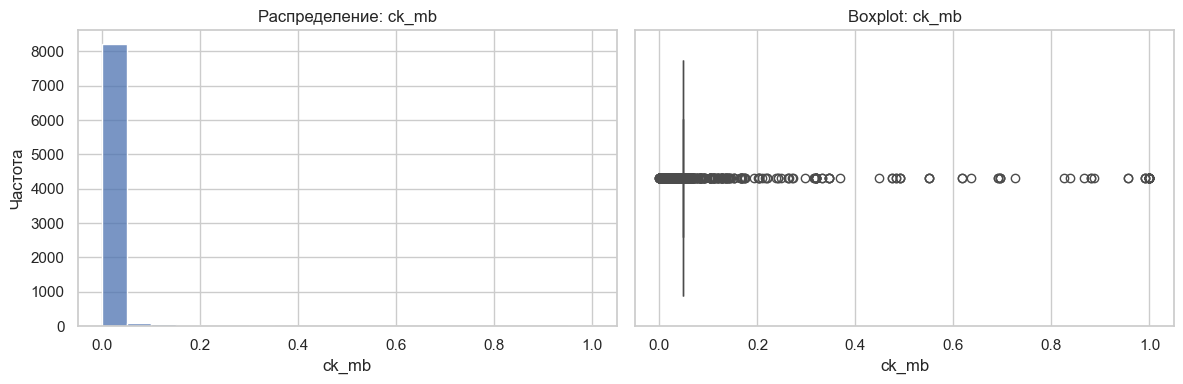

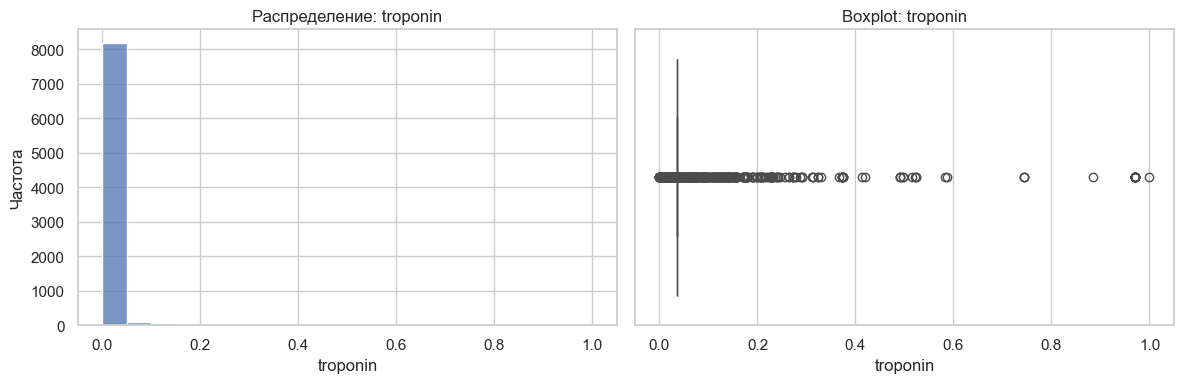

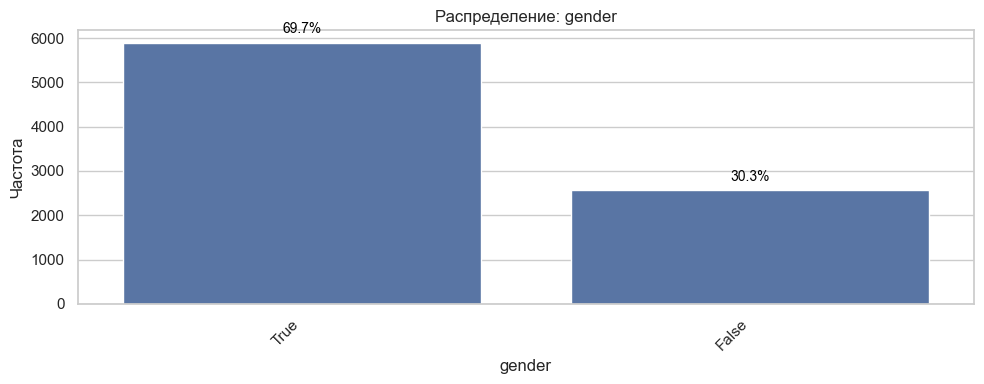

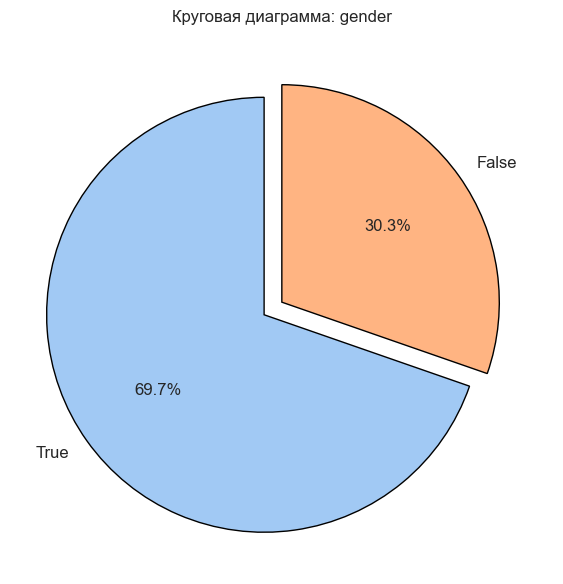

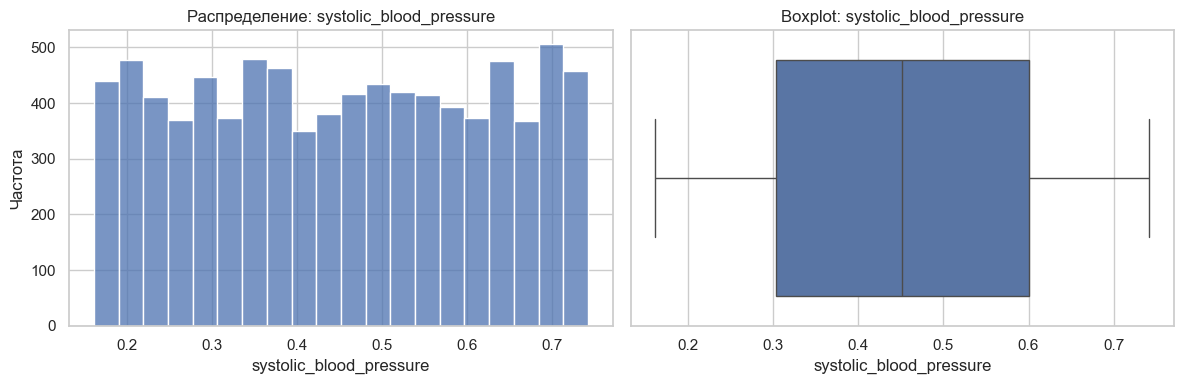

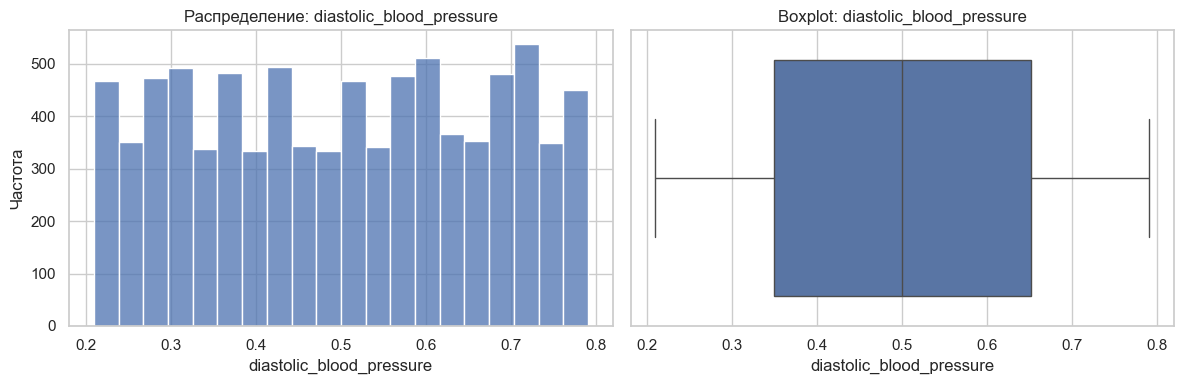

27938

In [66]:
sns.set_theme(style='whitegrid')

def annotate_countplot(ax, total):
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(
            f'{100 * height / total:.1f}%',
            (p.get_x() + p.get_width() / 2, height),
            ha='center', va='bottom',
            fontsize=10, color='black', xytext=(0, 5),
            textcoords='offset points'
        )

def plot_categorical(df, column):
    plt.figure(figsize=(10, 4))
    ax = sns.countplot(
        data=df,
        x=column,
        order=df[column].value_counts().index,
        color='C0'
    )
    plt.title(f'Распределение: {column}')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.xticks(rotation=45, ha='right')
    annotate_countplot(ax, total=len(df))
    plt.tight_layout()
    plt.show()

    if df[column].nunique() == 2:
        plt.figure(figsize=(6, 6))
        value_counts = df[column].value_counts()
        explode = [0.1] + [0] * (len(value_counts) - 1)
        value_counts.plot.pie(
            autopct='%1.1f%%',
            startangle=90,
            colors=sns.color_palette('pastel'),
            wedgeprops={'edgecolor': 'black'},
            explode=explode,
            textprops={'fontsize': 12}
        )
        plt.title(f'Круговая диаграмма: {column}')
        plt.ylabel('')
        plt.tight_layout()
        plt.show()
        plt.close()

def plot_numerical(df, column):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    sns.histplot(df[column], bins=20, color='C0', ax=axes[0])
    axes[0].set_title(f'Распределение: {column}')
    axes[0].set_xlabel(column)
    axes[0].set_ylabel('Частота')
    
    sns.boxplot(x=df[column], color='C0', ax=axes[1])
    axes[1].set_title(f'Boxplot: {column}')
    axes[1].set_xlabel(column)
    
    plt.tight_layout()
    plt.show()
    plt.close(fig)

def visualize_dataframe(df, exclude_columns=['id']):
    for column in df.columns:
        if column in exclude_columns:
            continue
        unique_vals = df[column].nunique()

        if pd.api.types.is_numeric_dtype(df[column]) and unique_vals < 20:
            df[column] = df[column].round(2)

        if unique_vals < 20:
            plot_categorical(df, column)
        else:
            plot_numerical(df, column)

visualize_dataframe(train, exclude_columns=['id'])
gc.collect()


Заметим что существует дисбаланс классов в целевом признаке.

## Корреляционные анализ данных

### Поиск линейной и монотонной зависимости между числовыми признаками

Найдём сильно коррелирующие признаки чтобы избавиться от утечек

In [67]:
train.corr(method='spearman')

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_(binary),blood_sugar,ck_mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id
age,1.000,-0.007,-0.005,-0.018,-0.000,0.394,-0.009,-0.004,0.007,-0.000,0.001,-0.002,0.016,0.020,-0.002,-0.001,0.003,0.005,-0.006,0.008,-0.024,-0.049,-0.004,0.017,0.005,-0.012,0.003
cholesterol,-0.007,1.000,0.002,-0.024,-0.015,0.019,-0.009,-0.012,0.023,0.004,0.002,0.001,-0.024,0.027,0.002,0.020,-0.014,0.011,0.010,0.019,0.007,0.004,-0.015,0.005,0.004,-0.000,-0.021
heart_rate,-0.005,0.002,1.000,0.000,-0.006,-0.010,0.009,0.003,0.007,-0.019,-0.003,0.009,-0.007,-0.005,0.002,0.002,0.010,-0.004,0.008,-0.002,0.015,0.003,0.004,-0.011,0.009,-0.026,-0.009
diabetes,-0.018,-0.024,0.000,1.000,-0.020,-0.000,0.017,0.004,-0.004,0.004,0.009,-0.007,0.012,0.003,0.004,-0.003,0.010,-0.001,-0.021,0.016,0.001,-0.020,-0.009,0.004,-0.005,-0.002,-0.013
family_history,-0.000,-0.015,-0.006,-0.020,1.000,0.008,-0.013,0.012,0.001,0.006,0.000,0.005,0.014,0.013,-0.005,-0.007,-0.004,0.009,-0.008,0.003,0.004,0.021,0.016,0.009,-0.004,0.015,-0.008
smoking,0.394,0.019,-0.010,-0.000,0.008,1.000,-0.002,0.011,0.006,-0.013,-0.003,-0.010,0.001,0.013,0.001,0.013,0.004,-0.004,-0.005,-0.005,-0.032,-0.078,-0.047,0.497,-0.004,-0.012,-0.002
obesity,-0.009,-0.009,0.009,0.017,-0.013,-0.002,1.000,-0.017,0.007,-0.008,0.008,-0.006,0.023,0.003,-0.002,0.003,-0.008,0.012,0.003,-0.015,-0.010,0.001,-0.003,-0.003,0.002,-0.019,0.005
alcohol_consumption,-0.004,-0.012,0.003,0.004,0.012,0.011,-0.017,1.000,-0.011,0.000,0.001,0.009,0.000,-0.014,-0.021,0.009,-0.007,0.004,0.005,-0.015,-0.012,-0.014,-0.000,-0.009,0.013,-0.013,0.009
exercise_hours_per_week,0.007,0.023,0.007,-0.004,0.001,0.006,0.007,-0.011,1.000,0.006,0.000,-0.012,-0.002,0.026,-0.016,0.006,0.003,0.009,0.003,0.009,-0.009,-0.011,-0.006,-0.002,-0.014,-0.009,0.018
diet,-0.000,0.004,-0.019,0.004,0.006,-0.013,-0.008,0.000,0.006,1.000,-0.019,0.005,-0.006,-0.002,0.007,-0.000,0.022,0.018,0.008,0.003,0.001,-0.003,-0.004,-0.008,-0.015,0.005,-0.003


Заметим что корреляция между признаками 'gender' и 'smoking' а также 'age' и 'smoking' крайне большая.
Это объясняется тем что 100% мужчин в таблице курят. Причём мужчин и женщин разное количество.
Чтобы избежать парадокса симпсона мы не будем выбрасывать признак пола. 
Мы могли бы выбрасить признак курение, так как он сильно связан с возрастом и полом. Мы будем использовать разные модели, в том числе регресии, поэтому сильная корреляция пары признаков может помешать определять веса.

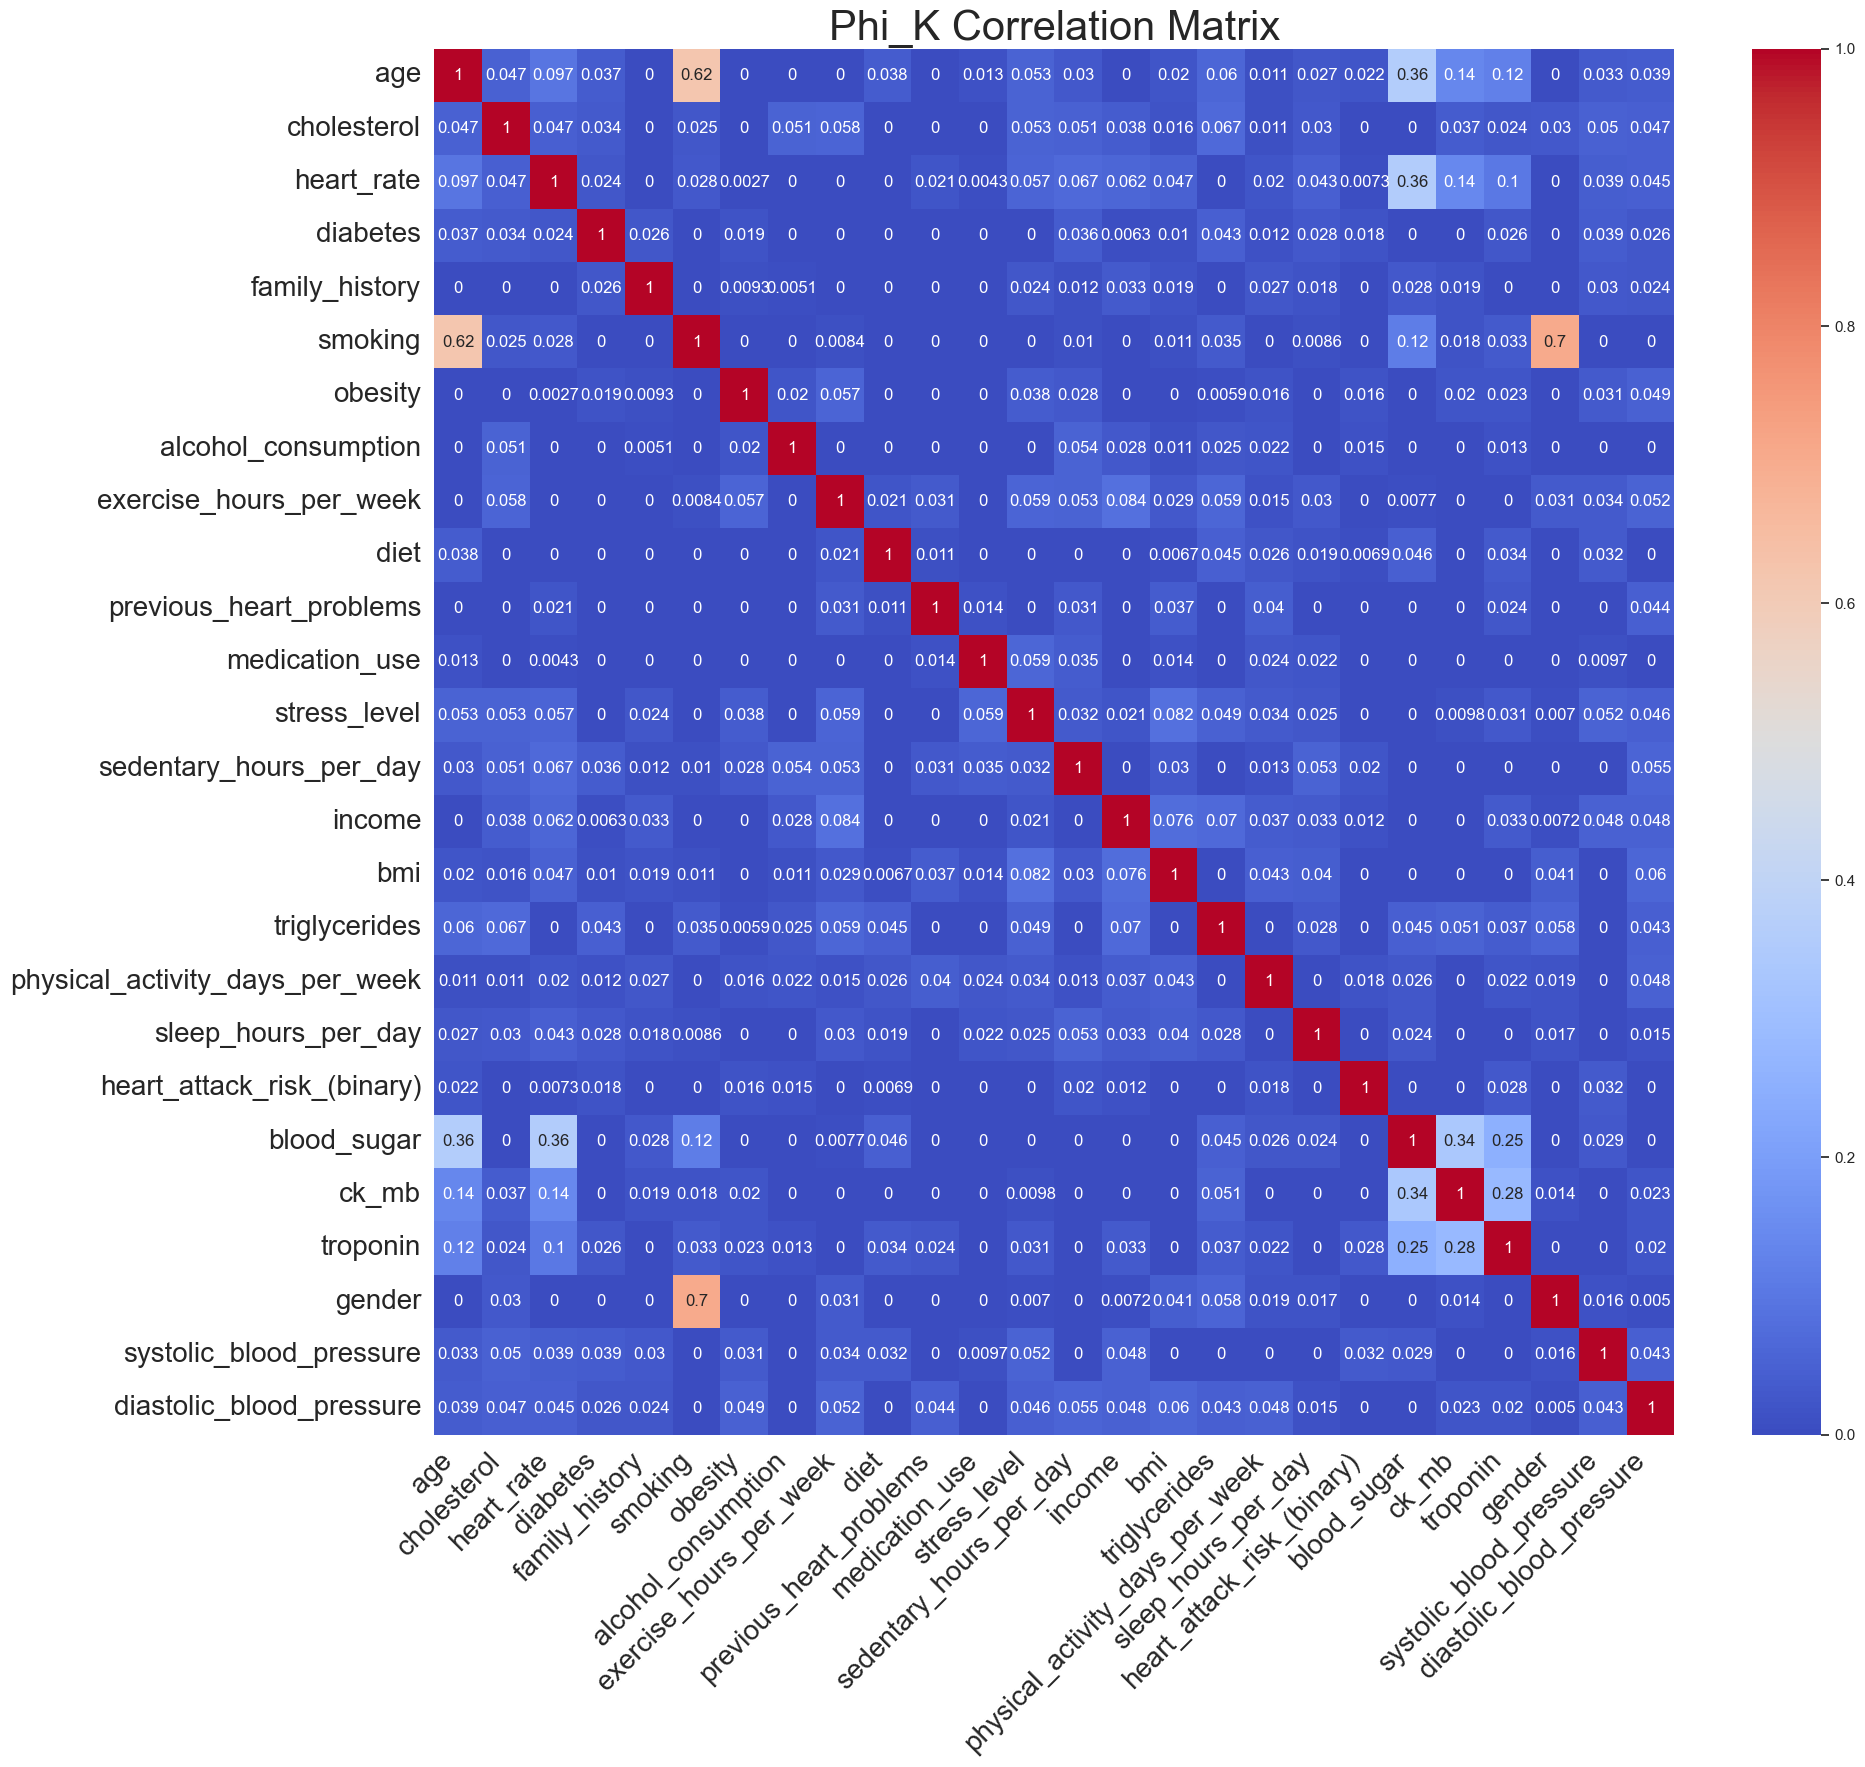

52624

In [68]:
interval_columns = [
    'age',
    'cholesterol',
    'heart_rate',
    'exercise_hours_per_week',
    'sedentary_hours_per_day',
    'income',
    'bmi',
    'triglycerides',
    'sleep_hours_per_day',
    'blood_sugar',
    'ck_mb',
    'troponin',
    'systolic_blood_pressure',
    'diastolic_blood_pressure'
]
corr_matrix = train[train.columns.drop('id')].phik_matrix(interval_cols= interval_columns)


plt.figure(figsize=(20, 18))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix', fontsize=30)
plt.xticks(rotation=45, ha='right', fontsize=20)

plt.yticks(fontsize=20)
plt.show()

del corr_matrix
gc.collect()

### Анализ важности признаков

Оценим информационную силу признаков(способность снижать неопределённость в предсказании целевого признака)
Это позволит оценить важность каждого признака изолированно

In [69]:

X = train.drop(columns=['id', 'heart_attack_risk_(binary)'])
y = train['heart_attack_risk_(binary)']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [70]:

mi_scores = mutual_info_classif(X_train, y_train, discrete_features='auto', random_state=42, n_jobs=-1)

mi_series = pd.Series(mi_scores, index=X_train.columns).sort_values(ascending=False)
print(mi_series)


sedentary_hours_per_day           0.028
exercise_hours_per_week           0.025
bmi                               0.020
income                            0.020
alcohol_consumption               0.010
cholesterol                       0.009
stress_level                      0.007
triglycerides                     0.007
diet                              0.006
ck_mb                             0.006
systolic_blood_pressure           0.006
obesity                           0.005
troponin                          0.005
family_history                    0.004
smoking                           0.004
diastolic_blood_pressure          0.003
blood_sugar                       0.002
gender                            0.001
age                               0.001
heart_rate                        0.000
diabetes                          0.000
previous_heart_problems           0.000
medication_use                    0.000
physical_activity_days_per_week   0.000
sleep_hours_per_day               0.000


Посмотрим насколько падает качество модели(случайного леса) при перемешивании значений каждого признака.
Это позволит оценить качество каждого признака в контексте остальных

In [71]:

X_train_val, X_test, y_train_val, y_test = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_val, y_train_val)

result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

importances = pd.Series(result.importances_mean, index=X_train.columns).sort_values(ascending=False)
print(importances)

del model, result
gc.collect()


cholesterol                        0.013
systolic_blood_pressure            0.012
exercise_hours_per_week            0.012
diastolic_blood_pressure           0.011
age                                0.010
triglycerides                      0.010
sedentary_hours_per_day            0.010
income                             0.006
previous_heart_problems            0.006
heart_rate                         0.006
alcohol_consumption                0.005
bmi                                0.005
sleep_hours_per_day                0.004
obesity                            0.004
physical_activity_days_per_week    0.004
diet                               0.003
gender                             0.002
medication_use                     0.002
stress_level                       0.001
family_history                     0.001
diabetes                           0.001
smoking                           -0.000
blood_sugar                       -0.000
troponin                          -0.002
ck_mb           

104

Для сохранения потенциально полезной информации мы удалим только те признаки, которые были отброшены сразу двумя проверками

In [72]:
# for i in ['']:
#     if i in train.columns: X_train = X_train.drop(columns=[i], axis=1)
#     if i in X_val.columns: X_val = X_val.drop(columns=[i], axis=1)

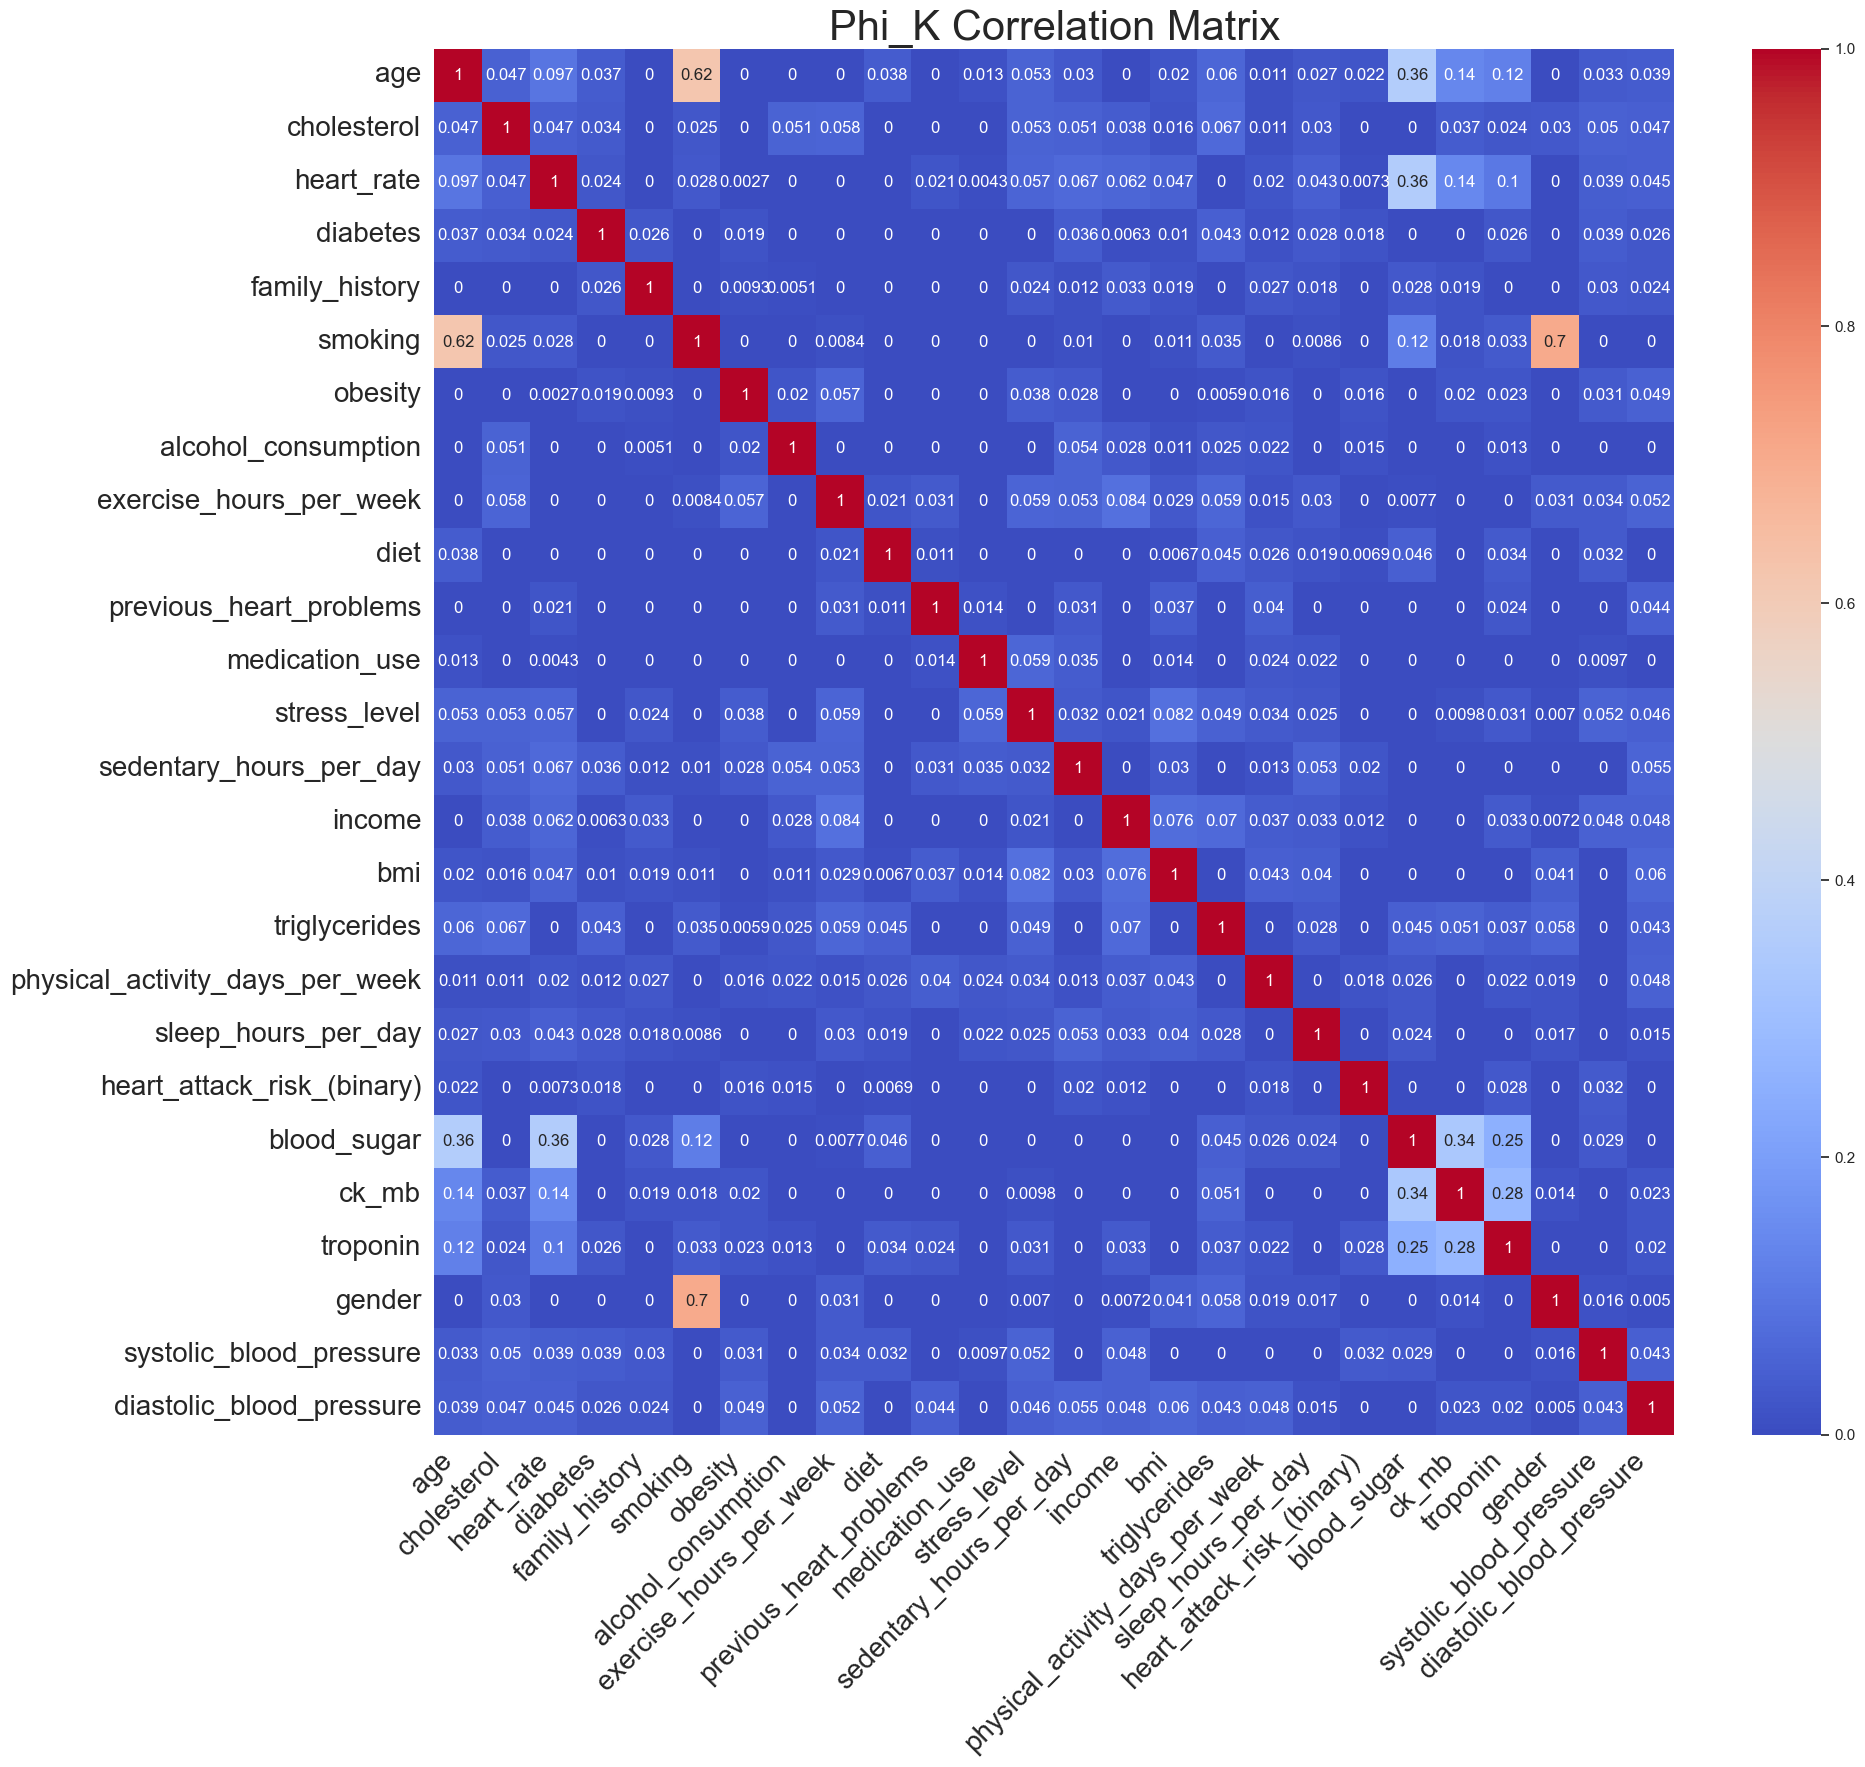

46065

In [73]:
interval_columns = [
    'age',
    'cholesterol',
    'heart_rate',
    'exercise_hours_per_week',
    'sedentary_hours_per_day',
    'income',
    'bmi',
    'triglycerides',
    'sleep_hours_per_day',
    'blood_sugar',
    'ck_mb',
    'troponin',
    'systolic_blood_pressure',
    'diastolic_blood_pressure'
]
corr_matrix = train[train.columns.drop('id')].phik_matrix(interval_cols= interval_columns)

plt.figure(figsize=(20, 18))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix', fontsize=30)
plt.xticks(rotation=45, ha='right', fontsize=20)

plt.yticks(fontsize=20)
plt.show()

del corr_matrix
gc.collect()

Видим что Курение сильно коррелировано с двумя другими признаками. Оно также не показало свою важность в ходе проверок.

Проверим глобальную мультиколлениарность признаков методом VIF(измеряет насколько изменится дисперсия оценок коэффициентов регрессии из-за мультиколлинеарности)

In [74]:
X_train_copy = X_train.copy()  
for col in X_train_copy.columns:
    if X_train_copy[col].dtype == 'bool':
        X_train_copy[col] = X_train_copy[col].astype(int)

def calculate_vif(X_train_copy):
    vif_data = pd.DataFrame()
    vif_data['feature'] = X_train_copy.columns
    vif_data['VIF'] = \
    [variance_inflation_factor(X_train_copy.values, i) for i in range(len(X_train_copy.columns))]
    return vif_data

vif_result = calculate_vif(X_train_copy)
print(vif_result)

del X_train_copy
gc.collect()

                            feature    VIF
0                               age  5.893
1                       cholesterol  3.905
2                        heart_rate  7.574
3                          diabetes  2.800
4                    family_history  1.943
5                           smoking 16.165
6                           obesity  1.977
7               alcohol_consumption  2.459
8           exercise_hours_per_week  3.931
9                              diet  2.457
10          previous_heart_problems  1.976
11                   medication_use  1.983
12                     stress_level  4.472
13          sedentary_hours_per_day  3.844
14                           income  3.835
15                              bmi  3.856
16                    triglycerides  3.870
17  physical_activity_days_per_week  3.320
18              sleep_hours_per_day  3.214
19                      blood_sugar  9.484
20                            ck_mb  1.452
21                         troponin  1.393
22         

0

Значение VIF для курения больше 10, что говорит о сильной мультиколлинеарности в признаках, которая будет вредить нашей модели

Также мы сократим размерность данных через объединение связанных по смыслу признаков

Используем стандартную формулу для среднего артериального давления.

объединим липиды в один признак, показывающий их соотношение(избегаем деления на малые значения)

признаки физической активности тоже можно обединить

биологический возраст и семейный анамнез можно объединить в один биологический фактор риска

индекс массы тела и уровень сахара в крови показывают на общий вредоносный механизм 

сон отвечает за восстановление, а стресс за напряжение организма, так что они говрят об одном и том же

In [75]:
for d in [X_train, X_val]:
    d['mean_pressure'] = (2 * d['diastolic_blood_pressure'] * d['systolic_blood_pressure']) / 3
    d['lipid_ratio'] = d['triglycerides'] / (d['cholesterol'] + 1)
    d['activity_balance_score'] = d['exercise_hours_per_week'] / (1 + d['sedentary_hours_per_day'])
    d['risk_age'] = d['age'] * (1 + d['family_history'])
    d['health_index'] = (d['bmi'] * d['blood_sugar'])
    d['sleep_stress_ratio'] = d['sleep_hours_per_day'] / (d['stress_level'] + 1)


Удалим объдинённые признаки, а также курение(слишком скоррелировано) и ожирение(информация о нём уже содержиться в bmi)

In [76]:
for i in ['diastolic_blood_pressure', 'systolic_blood_pressure', 'cholesterol', 'triglycerides', 
          'blood_sugar', 'bmi',
              'heart_rate', 
            'exercise_hours_per_week', 'sedentary_hours_per_day', 
                'sleep_hours_per_day', 'stress_level', 'family_history', 
                  'age', 'obesity', 'smoking']:
    if i in X_train.columns: X_train = X_train.drop(columns=[i], axis=1)
    if i in X_val.columns: X_val = X_val.drop(columns=[i], axis=1)

In [77]:
X_train_copy = X_train.copy()  
for col in X_train_copy.columns:
    if X_train_copy[col].dtype == 'bool':
        X_train_copy[col] = X_train_copy[col].astype(int)

vif_result = calculate_vif(X_train_copy)
print(vif_result)

del X_train_copy
gc.collect()

                            feature   VIF
0                          diabetes 2.689
1               alcohol_consumption 2.376
2                              diet 2.395
3           previous_heart_problems 1.937
4                    medication_use 1.934
5                            income 3.573
6   physical_activity_days_per_week 3.161
7                             ck_mb 1.432
8                          troponin 1.379
9                            gender 3.037
10                    mean_pressure 4.108
11                      lipid_ratio 3.285
12           activity_balance_score 3.328
13                         risk_age 3.151
14                     health_index 2.944
15               sleep_stress_ratio 1.950


0

Видим что скоррелированность признаков сильно снизилась, то есть каждый признак стал полезнее для модели.

Число признаков теперь приблизилось к log_2 (Число строк) что уменьшает проблему гиперразмерного пространства, в котром все точки выглядят одинаково


## Использование пайплайнов

Так как задача проекта это предсказание наличия риска сердечного приступа, то ложноотрицательные результаты для нас намного опаснее ложноположительных, поэтому применим метрику f1 для поиска лучшей модели, затем подберём порог классификации для того чтобы сделать recall>0.8 

In [78]:

target_column = ['heart_attack_risk_(binary)']

columns = X_train.columns
bool_columns = X_train.select_dtypes(include=['bool']).columns
num_columns = X_train.select_dtypes(include=['int64', 'float64']).columns


log_transformer = FunctionTransformer(np.log1p, validate=True)

skewed_cols = ['ck_mb', 'troponin']
robust_cols = ['health_index']
normal_cols = list(set(num_columns) - set(skewed_cols) - set(robust_cols))

preprocessor = ColumnTransformer(
    transformers=[
        ('log_robust', Pipeline([
            ('log', log_transformer),
            ('scaler', RobustScaler())
        ]), skewed_cols),

        ('robust_only', RobustScaler(), robust_cols),

        ('standard', StandardScaler(), normal_cols),

        ('bool', FunctionTransformer(bool_to_int), bool_columns)
    ],
    remainder='drop'  
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('models', RandomForestClassifier(n_estimators=100, random_state=42))
])

param_grid = [ 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 20),
        'models__weights': ['uniform', 'distance']
    }
    ,
    {
        'models': [DecisionTreeClassifier(random_state=42)],
        'models__max_depth': range(2, 18),
        'models__min_samples_leaf': [2, 5, 10],
        'models__min_samples_split': [2, 5, 10]
    }
    ,
    {
        'models': [SVC(random_state=42)],
        # 'models__C': range(1, 6),
        'models__kernel': ['rbf', 'poly'],
        'models__decision_function_shape': ['ovr', 'ovo']
    }
    ,
    {
        'models': [RandomForestClassifier(random_state=42, n_jobs=-1)],
        'models__n_estimators': [100, 200],
        'models__max_depth': [5, 10],
        'models__min_samples_split': [2, 5],
        'models__class_weight': [None, 'balanced']
    },
    {
        'models': [LGBMClassifier(random_state=42, n_jobs=-1)],
        'models__num_leaves': [15, 31],
        'models__max_depth': [-1, 5, 10],
        'models__min_child_samples': [10, 20],
        'models__class_weight': [None, 'balanced']
    }
    ,
    {
        'models': [LogisticRegression(random_state=42, solver='saga', max_iter=45000)],
        'models__class_weight': [None, 'balanced'],
        # 'models__C': range(1, 6)
    }
] 

grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)
grid.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', grid.best_estimator_, grid.best_score_) 


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('log_robust',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                       validate=True)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['ck_mb', 'troponin']),
                                                 ('robust_only', RobustScaler(),
                                                  ['health_index']),
                                                 ('standard', StandardScaler(),
                                                  ['risk_age', 'lipid_ratio',
                                       

## Оценка и загрузка модели

In [79]:
grid.best_estimator_.fit(X_train, y_train)
y_pred = grid.best_estimator_.predict(X_val)
print('Точность на валидационной выборке:', accuracy_score(y_val, y_pred))
print('Полнота на валидационной выборке:', recall_score(y_val, y_pred))
print('Точность на валидационной выборке:', precision_score(y_val, y_pred))
print('F1-мера на валидационной выборке:', f1_score(y_val, y_pred))
print('ROC AUC на валидационной выборке:', roc_auc_score(y_val, y_pred))

Точность на валидационной выборке: 0.507400828892836
Полнота на валидационной выборке: 0.5257048092868989
Точность на валидационной выборке: 0.36732329084588644
F1-мера на валидационной выборке: 0.4324693042291951
ROC AUC на валидационной выборке: 0.5114711891738362


### Найдём лучший порог классификации

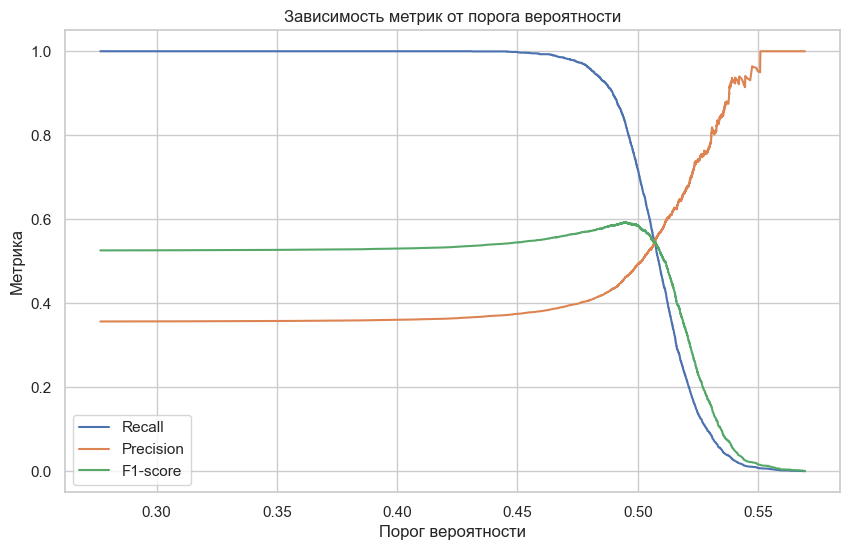

In [80]:
y_scores = grid.best_estimator_.predict_proba(X_train)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_train, y_scores)

f1 = 2 * (precision * recall) / (precision + recall + 1e-10) 

plt.figure(figsize=(10, 6))
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, f1[:-1], label='F1-score')
plt.xlabel('Порог вероятности')
plt.ylabel('Метрика')
plt.title('Зависимость метрик от порога вероятности')
plt.legend()
plt.grid(True)

plt.show()

In [81]:
X_train, X_val, y_train, y_val = train_test_split(train.drop(columns='heart_attack_risk_(binary)'), 
                                                  train['heart_attack_risk_(binary)']
                                                  , test_size=0.2, stratify=y, random_state=42)

threshold = 0.4848
threshold_classifier = ThresholdClassifierWithTransform(grid.best_estimator_, threshold=threshold)
threshold_classifier.fit(X_train, y_train)
y_pred = threshold_classifier.predict(X_val)
print('Точность на валидационной выборке:', accuracy_score(y_val, y_pred))
print('Полнота на валидационной выборке:', recall_score(y_val, y_pred))

Точность на валидационной выборке: 0.4339846062759029
Полнота на валидационной выборке: 0.8258706467661692


### Загрузка модели

In [ ]:
threshold_model = ThresholdClassifierWithTransform(grid.best_estimator_, threshold=0.4848)
threshold_model.fit(train.drop(columns=['heart_attack_risk_(binary)', 'obesity', 'smoking']), train['heart_attack_risk_(binary)'])

model_save_path = MODEL_PATH / "best_model.joblib"

joblib.dump(threshold_model, model_save_path)


if model_save_path.exists():
    print(f"✅ Модель сохранена по пути: {model_save_path}")
else:
    print("❌ Ошибка сохранения модели!")

✅ Модель сохранена по пути: c:\Users\Юра\VS_Code\FastAPI_ML-project\FastAPI_ML-project\models\best_model.joblib
